<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>I - Introduction</h2>

<p>
Ce notebook s’inscrit dans une démarche d’<b>optimisation progressive de la
représentation textuelle</b> pour un problème de classification multi-classes
de produits. L’objectif n’est pas uniquement d’atteindre un score élevé, mais
également de <b>comprendre les mécanismes de décision du modèle</b> et de
justifier chaque choix méthodologique de manière rigoureuse.
</p>

<p>
L’approche adoptée repose sur une exploration <b>itérative et structurée</b> des
différentes composantes du pipeline de traitement du texte. Chaque étape vise à
répondre à une question précise, en s’appuyant sur des comparaisons contrôlées et
des métriques homogènes.
</p>

<p>
Le travail débute par le <b>choix du modèle linéaire de référence</b> et de la
vectorisation de base (TF-IDF), avant d’explorer successivement l’impact :
</p>

<ul>
  <li>du type de vectorisation (TF-IDF vs Count)</li>
  <li>des <i>n-grams</i> de mots et de caractères</li>
  <li>de la séparation explicite entre <b>titre</b> et <b>description</b></li>
  <li>de la pondération différentielle du titre</li>
  <li>du réglage du coefficient de régularisation <code>C</code></li>
</ul>

<p>
À chaque étape, les choix retenus sont motivés par un compromis entre
<b>performance en validation</b>, <b>temps de calcul</b> et
<b>capacité de généralisation</b>. Les configurations n’apportant qu’un gain
marginal ou instable sont volontairement écartées afin de conserver un modèle
robuste et interprétable.
</p>

<p>
Une attention particulière est également portée à l’<b>analyse qualitative des
features</b>, notamment à travers l’étude des coefficients du SVM par catégorie.
Cette analyse permet de relier les performances observées aux caractéristiques
sémantiques des données (jargon métier, noms propres, styles de description) et
de mettre en évidence des comportements différenciés selon les classes.
</p>

<p>
Enfin, ce notebook constitue une <b>étape préparatoire</b> à des stratégies plus
avancées de fusion ou de stacking, en fournissant un socle textuel optimisé,
interprétable et solidement justifié.
</p>

</div>

In [ ]:
import sys

sys.path.insert(0, '../exploratory')
from data import load_data
from features.text import FillNaTextTransformer, MergeTextTransformer, FeatureWeighter
from models.evaluation import evaluate_pipeline
from visualization import plot_classification_report, plot_features_importance

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, log_loss

import seaborn as sns
import matplotlib.pyplot as plt

import joblib

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2>II — Étude comparative des stratégies de vectorisation</h2>

<h3>1 - Choix du modèle linéaire</h3>

<p>
Cette première étape vise à <b>sélectionner un classifieur linéaire adapté</b>,
en s’appuyant sur une <b>vectorisation TF-IDF figée</b> au niveau des mots.
</p>

<p>
Plusieurs modèles linéaires sont évalués dans un cadre strictement identique,
afin d’isoler l’impact du classifieur indépendamment des choix de
représentation textuelle.
</p>

<p>
La configuration retenue à l’issue de cette étape constitue le point de départ
des optimisations ultérieures, chaque amélioration étant ensuite évaluée par
rapport à la meilleure configuration obtenue à l’étape précédente.
</p>

</div>


In [42]:
X_train, X_val, X_test, y_train, y_val, y_test = load_data(splitted=True).values()
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train.tolist())
y_val = encoder.transform(y_val.tolist())
y_test = encoder.transform(y_test.tolist())

In [7]:
def make_vectorizer(tfidf=True, ngram_range=(1, 2), max_features=250_000, max_df=0.95, binary=False, analyzer="word"):
    vectorizer_params = {
        'ngram_range' : ngram_range,
        'min_df' : 2,
        'max_df' : max_df,
        'sublinear_tf' : True,
        'lowercase' : True,
        'max_features' : max_features,
        'binary' : binary,
        'analyzer' : analyzer
    }
    if tfidf:
        vectorizer_params.pop('binary')
        vectorizer = TfidfVectorizer(**vectorizer_params)
    else:
        vectorizer_params.pop('sublinear_tf')
        vectorizer = CountVectorizer(**vectorizer_params)
        
    return vectorizer

In [7]:
# modèles à tester
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "LinearSVC": LinearSVC(),
    "SGD_hinge": SGDClassifier(),
    "RidgeClassifier": RidgeClassifier(),
    "ComplementNB": ComplementNB(),
}

results_model = {}

for name, model in models.items():
    vectorizer = make_vectorizer()
    pipe = Pipeline([
        ("merger", MergeTextTransformer()),
        ("vectorizer", vectorizer),
        ("clf", model)
    ])
    metrics = evaluate_pipeline(pipe, X_train, y_train, X_val, y_val)
    results_model[name] = metrics

pd.DataFrame(results_model).T.sort_values("f1_val", ascending=False).round(3)

,f1_train,f1_val,train_time_s,pred_time_s
LinearSVC,0.991,0.838,28.044,11.093
RidgeClassifier,0.977,0.833,73.428,10.825
LogisticRegression,0.903,0.816,234.674,17.124
SGD_hinge,0.893,0.803,18.731,14.154
ComplementNB,0.866,0.772,13.735,11.433


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
À l’issue de cette première étape, le modèle <b>LinearSVC</b> est retenu.
Il présente le meilleur compromis entre <b>performance en validation</b>,
<b>stabilité des résultats</b> et <b>coût de calcul</b>, dans un cadre où la
vectorisation TF-IDF est maintenue fixe.
</p>

<p>
Ce choix fournit une base solide pour la suite de l’analyse, les étapes suivantes
visant désormais à optimiser la représentation textuelle tout en conservant ce
classifieur.
</p>

</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3>2 - Comparaison des méthodes de vectorisation</h3>

<p>
Cette étape vise à évaluer l’impact du <b>choix de la méthode de vectorisation
lexicale</b> sur les performances du modèle, en conservant le classifieur
<b>LinearSVC</b> retenu précédemment.
</p>

<p>
En complément de la vectorisation TF-IDF utilisée jusqu’à présent, nous testons
des variantes basées sur <b>CountVectorizer</b>, avec et sans binarisation des
comptes (<code>binary=True</code>), afin de déterminer si une représentation plus
simple ou plus brute des occurrences peut améliorer la capacité de
discrimination du modèle.
</p>

</div>


In [9]:
model = models['LinearSVC']

best_metrics = results_model.get('LinearSVC')
best_metrics['delta'] = 0
best_f1 = best_metrics['f1_val']

vectorizers = {
    "count": make_vectorizer(tfidf=False, binary=False),
    "count_binary": make_vectorizer(tfidf=False, binary=True),
}

results_vec = {
    "tfidf": best_metrics
}

for name, vec in vectorizers.items():
    pipe = Pipeline([
        ("merger", MergeTextTransformer()),
        ("vectorizer", vec),
        ("clf", model)
    ])
    metrics = evaluate_pipeline(pipe, X_train, y_train, X_val, y_val)
    metrics["delta"] = metrics["f1_val"] - best_f1
    results_vec[name] = metrics
pd.DataFrame(results_vec).T.sort_values("delta", ascending=False).round(3)

C:\Users\gabyd\anaconda3\envs\ds_rakuten\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\gabyd\anaconda3\envs\ds_rakuten\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,f1_train,f1_val,train_time_s,pred_time_s,delta
tfidf,0.991,0.838,28.044,11.093,0.00
count_binary,0.998,0.818,74.739,11.385,-0.02
count,0.998,0.808,90.624,10.671,-0.03


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
Les approches basées sur <b>CountVectorizer</b> atteignent des scores très élevés
sur le jeu d’entraînement, traduisant une forte capacité d’ajustement aux données.
Cependant, cette performance ne se transpose pas sur le jeu de validation, ce qui
indique un sur-apprentissage plus marqué.
</p>

<p>
La vectorisation TF-IDF est donc conservée pour la suite des expériences, servant
de base à l’étude des paramètres plus fins de la représentation lexicale.
</p>

</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3>3 - Influence de la taille des n-grams lexicaux</h3>

<p>
Cette étape vise à analyser l’impact de la <b>taille des n-grams lexicaux</b> sur
les performances du modèle, en s’appuyant sur la vectorisation TF-IDF retenue
précédemment et le classifieur <b>LinearSVC</b>.
</p>

<p>
Différentes plages de n-grams sont évaluées afin de déterminer le compromis le
plus pertinent entre expressivité de la représentation, capacité de
généralisation et coût de calcul.
</p>

</div>


In [10]:
vectorizers = {
    "word_1gram": make_vectorizer(tfidf=True, ngram_range=(1, 1), max_features=250_000, binary=False),
    "word_1_3gram": make_vectorizer(tfidf=True, ngram_range=(1, 3), max_features=250_000, binary=False)
}

results_ngrams = {
    "word_1_2gram": best_metrics
}

for name, vectorizer in vectorizers.items():
    pipe = Pipeline([
        ("merger", MergeTextTransformer()),
        ("vectorizer", vectorizer),
        ("clf", model)
    ])
    metrics = evaluate_pipeline(pipe, X_train, y_train, X_val, y_val)
    metrics["delta"] = metrics["f1_val"] - best_f1
    results_ngrams[name] = metrics

pd.DataFrame(results_ngrams).T.sort_values("delta", ascending=False).round(3)

,f1_train,f1_val,train_time_s,pred_time_s,delta
word_1_2gram,0.991,0.838,28.044,11.093,0.000
word_1_3gram,0.987,0.837,51.739,15.380,-0.001
word_1gram,0.983,0.833,10.629,5.269,-0.005


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
Les résultats montrent que l’utilisation de <b>n-grams de mots (1,2)</b> offre le
meilleur compromis entre performance, temps d’entraînement et coût
d’inférence. L’extension aux <b>n-grams (1,3)</b> n’apporte pas de gain en
validation, tout en augmentant significativement le temps de calcul.
</p>

<p>
À l’inverse, la restriction aux <b>unigrammes</b> entraîne une légère dégradation
des performances, indiquant que les bigrammes capturent des co-occurrences
utiles pour la discrimination des catégories.
</p>

<p>
La configuration <b>word-level (1,2)</b> est donc retenue pour la suite des
expériences.
</p>

</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3>4 - Ajout des n-grams de caractères</h3>

<p>
Cette étape vise à enrichir la représentation textuelle en intégrant des
<b>n-grams de caractères</b>, en complément des n-grams lexicaux retenus
précédemment.
</p>

<p>
Les n-grams de caractères permettent de capturer des variations
orthographiques, des références produits, des formats spécifiques ainsi que
certaines informations numériques partiellement normalisées, qui peuvent être
mal prises en compte par une vectorisation strictement lexicale.
</p>

<p>
L’objectif est d’évaluer si cette représentation plus fine améliore la capacité
de discrimination du modèle, en particulier pour les catégories présentant des
descriptions hétérogènes ou fortement dépendantes de motifs courts.
</p>

</div>


In [11]:
word_vec = make_vectorizer()
char_vec_3_5 = make_vectorizer(analyzer="char", max_df=1.0, max_features=150_000, ngram_range=(3,5))
char_vec_4_6 = make_vectorizer(analyzer="char", max_df=1.0, max_features=150_000, ngram_range=(4,6))

vectorizers = {
    "word_char_3_5": FeatureUnion([
        ("word", word_vec),
        ("char", char_vec_3_5)
    ]),
    "word_char_4_6": FeatureUnion([
        ("word", word_vec),
        ("char", char_vec_4_6)
    ])
}

results_char = {
    "word_only": best_metrics
}

for name, vectorizer in vectorizers.items():
    pipe = Pipeline([
        ("merger", MergeTextTransformer()),
        ("vectorizer", vectorizer),
        ("clf", model)
    ])
    metrics = evaluate_pipeline(pipe, X_train, y_train, X_val, y_val)
    metrics["delta"] = metrics["f1_val"] - best_f1
    results_char[name] = metrics

pd.DataFrame(results_char).T.sort_values("delta", ascending=False).round(3)

,f1_train,f1_val,train_time_s,pred_time_s,delta
word_char_3_5,0.997,0.860,168.064,105.868,0.022
word_char_4_6,0.996,0.857,260.506,144.873,0.019
word_only,0.991,0.838,28.044,11.093,0.000


In [12]:
best_metrics = results_char.get('word_char_3_5')
best_metrics['delta'] = 0
best_f1 = best_metrics['f1_val']

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
L’ajout des <b>n-grams de caractères</b> conduit à une amélioration nette des
performances en validation par rapport à une vectorisation uniquement lexicale.
La configuration combinant <b>n-grams de mots</b> et <b>char-ngrams (3,5)</b>
présente le meilleur compromis, avec un gain significatif de performance tout en
maîtrisant le coût de calcul.
</p>

<p>
L’extension à des <b>char-ngrams (4,6)</b> n’apporte pas d’amélioration
supplémentaire et entraîne une augmentation notable des temps
d’entraînement et d’inférence.
</p>

<p>
La configuration <b>word + char (3,5)</b> est donc retenue comme nouvelle
référence pour la suite des expérimentations.
</p>

</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3>5 — Séparation du titre et de la description</h3>

<p>
Dans les descriptions de produits, le <b>titre</b> concentre généralement les
informations les plus discriminantes (marque, modèle, format), tandis que la
<b>description</b> apporte un complément plus variable et souvent plus
redondant.
</p>

<p>
Cette étape vise à évaluer l’intérêt d’une <b>séparation explicite</b> entre le
titre et la description, en leur appliquant une <b>pondération
différentielle</b>, afin de renforcer l’influence du titre dans la décision du
modèle.
</p>

<p>
L’objectif est de déterminer si cette distinction permet d’améliorer la
discrimination sans introduire de sur-apprentissage.
</p>

</div>


In [8]:
def make_weighted_vectorizer(title_weight=1.2):
    vectorizer = ColumnTransformer([
        ("title", Pipeline([
            ("tfidf", FeatureUnion([
                ("word", make_vectorizer(max_features=120_000)),
                ("char", make_vectorizer(analyzer="char", max_df=1.0, max_features=80_000, ngram_range=(3,5))),
            ])),
            ("weight", FeatureWeighter(weight=title_weight))
        ]), "designation"),
        ("desc", FeatureUnion([
            ("word", make_vectorizer(max_features=150_000)),
            ("char", make_vectorizer(analyzer="char", max_df=1.0, max_features=100_000, ngram_range=(3,5)))
        ]), "description")
    ])
    return vectorizer

,f1_train,f1_val,train_time_s,pred_time_s,delta
merge,0.9968,0.8601,168.0636,105.8675,0.0000
split_w_1.0,0.9988,0.8695,224.6490,116.1889,0.0094
split_w_1.2,0.9991,0.8697,184.9533,99.6174,0.0096
split_w_1.4,0.9992,0.8686,181.1881,98.2781,0.0085
split_w_1.6,0.9993,0.8674,189.3692,97.3386,0.0073


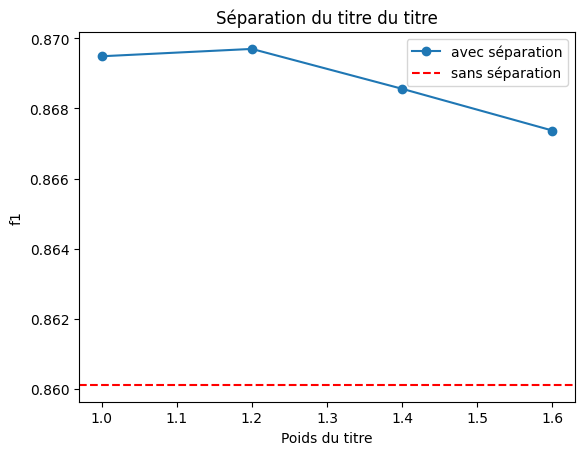

In [14]:
title_weights = [1.0, 1.2, 1.4, 1.6]

results_weight = {
    "merge": best_metrics
}

for w in title_weights:
    pipe = Pipeline([
        ("fillna", FillNaTextTransformer()),
        ("vectorizer", make_weighted_vectorizer(w)),
        ("clf", model)
    ])
    metrics = evaluate_pipeline(pipe, X_train, y_train, X_val, y_val)
    metrics["delta"] = metrics["f1_val"] - best_f1
    results_weight[f"split_w_{w}"] = metrics
    
res = pd.DataFrame(results_weight).T.round(4)
display(res)
plt.plot(title_weights, [results_weight[f"split_w_{w}"]['f1_val'] for w in title_weights], marker="o", label='avec séparation')
plt.xlabel("Poids du titre")
plt.ylabel("f1")
plt.axhline(best_f1, c='r', linestyle='--', label='sans séparation')
plt.title("Séparation du titre du titre")
plt.legend()
plt.show()

In [15]:
best_metrics = results_weight.get('split_w_1.2')
best_metrics['delta'] = 0
best_f1 = best_metrics['f1_val']

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
La séparation explicite du <b>titre</b> et de la <b>description</b>, associée à une
pondération différenciée, permet d’améliorer les performances en validation par
rapport à une représentation fusionnée. Ce gain confirme que le titre concentre
une information particulièrement discriminante pour la classification des
produits.
</p>

<p>
Une <b>pondération modérée du titre</b>, autour de <b>1.2</b>, offre le meilleur
compromis entre performance et stabilité. Des pondérations plus élevées
n’apportent pas de gain supplémentaire et tendent à accentuer le
sur-apprentissage.
</p>

<p>
L’augmentation progressive du score sur le jeu d’entraînement, nettement plus
rapide que sur le jeu de validation, met en évidence un <b>sur-ajustement</b>
croissant du modèle, justifiant l’introduction d’une étape de régularisation.
</p>

</div>

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h3>6 — Régularisation du classifieur</h3>

<p>
Cette étape vise à contrôler le compromis <b>biais / variance</b> du modèle en
ajustant le paramètre de régularisation <code>C</code> du <b>SVM linéaire</b>, tout en
conservant la configuration de représentation textuelle retenue précédemment.
</p>

<p>
La régularisation permet de limiter le sur-apprentissage observé lors de
l’introduction de la pondération titre / description, en contraignant la
complexité du modèle et en améliorant sa capacité de généralisation.
</p>

<p>
Différentes valeurs de <code>C</code> sont testées afin d’identifier le meilleur
équilibre entre performance en validation et robustesse du modèle.
</p>

</div>

,f1_train,f1_val,train_time_s,pred_time_s,delta
C_0.03,0.935729,0.848923,128.192930,91.456263,-0.020777
C_0.05,0.958634,0.859178,124.635875,91.274923,-0.010522
C_0.1,0.981111,0.866488,147.550636,101.483574,-0.003212
C_0.2,0.993149,0.869592,160.876571,95.285013,-0.000108
C_0.3,0.996446,0.869376,138.203310,100.328856,-0.000324
C_0.5,0.998125,0.869026,152.281765,96.816055,-0.000674
C_1.0,0.999071,0.869700,184.953252,99.617361,0.000000


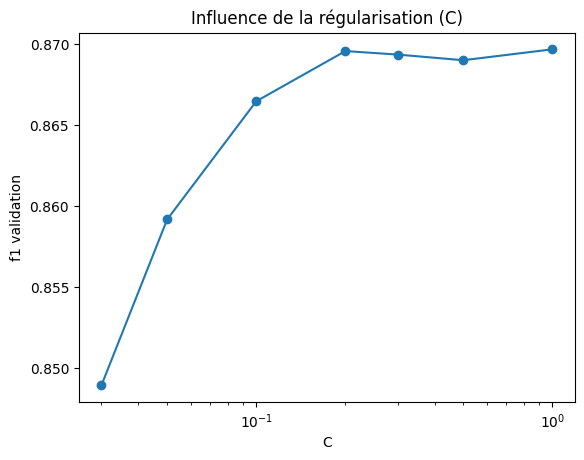

In [31]:
C_grid = [0.03, 0.05, 0.1, 0.2, 0.3, 0.5]

results_C = {
    "C_1.0": best_metrics
}

for C in C_grid:
    pipe = Pipeline([
        ("fillna", FillNaTextTransformer()),
        ("vectorizer", make_weighted_vectorizer(1.2)),
        ("clf", LinearSVC(C=C))
    ])
    metrics = evaluate_pipeline(pipe, X_train, y_train, X_val, y_val)
    metrics["delta"] = metrics["f1_val"] - best_f1
    results_C[f"C_{C}"] = metrics

pd.DataFrame(results_C).T.sort_values("delta", ascending=False).round(4)

res = pd.DataFrame(results_C).T.sort_index()

display(res)

plt.plot([float(idx[2:]) for idx in res.index], res["f1_val"], marker="o")
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("f1 validation")
plt.title("Influence de la régularisation (C)")

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
L’analyse du paramètre de régularisation <code>C</code> met en évidence un
<b>plateau de performance</b> en validation pour des valeurs comprises entre
<b>0.2 et 1.0</b>, avec des scores de F1 weighted très proches.
</p>

<p>
Dans cet intervalle, l’augmentation de <code>C</code> conduit principalement à une
hausse du score sur le jeu d’entraînement, sans gain significatif en validation,
traduisant un <b>sur-apprentissage progressif</b>.
</p>

<p>
Bien que <b>C = 1.0</b> atteigne un score de validation similaire, <b>C = 0.2</b> est privilégié car il offre le même niveau de performance avec une régularisation plus forte, conduisant à un modèle plus conservateur.
</p>

</div>

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>III - Modèle texte final retenu</h2>

<p>
À l’issue des différentes étapes d’optimisation, nous retenons une configuration
textuelle stable et performante, issue d’une démarche incrémentale et
entièrement validée expérimentalement.
</p>

<p>
Le modèle final repose sur les choix suivants :
</p>

<ul>
  <li>vectorisation <b>TF-IDF word-level</b> (n-grams 1–2),</li>
  <li>ajout de <b>n-grams de caractères</b> (3–5),</li>
  <li>séparation explicite du <b>titre</b> et de la <b>description</b>,</li>
  <li>pondération modérée du titre,</li>
  <li>classifieur <b>LinearSVC</b> avec un coefficient de régularisation
      <b>C = 0.2</b>.</li>
</ul>

</div>

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h3>1 - Calibration du modèle pour le stacking</h3>

<p>
Dans le cadre de la stratégie de <b>stacking</b>, les sorties des modèles de base
doivent être exprimées sous forme de probabilités comparables entre modèles.
Le classifieur LinearSVC produisant des scores marginaux, une étape de
<b>calibration</b> est nécessaire.
</p>

<p>
Le modèle texte est entraîné uniquement sur le jeu <b>train</b>, puis calibré afin
de transformer ses scores en probabilités exploitables par le méta-classifieur.
Les probabilités calibrées (ou logits associés) sont ensuite <b>sauvegardées</b>
pour être directement utilisées dans les notebooks de stacking.
</p>

<p>
Cette procédure garantit l’absence de fuite d’information entre les différents
niveaux du modèle et assure la cohérence des entrées du méta-modèle.
</p>

</div>

In [43]:
model = Pipeline([
    ("fillna", FillNaTextTransformer()),
    ("vectorizer", make_weighted_vectorizer(1.2)),
    ("clf", LinearSVC(C=0.2))
])

calibrated_model = CalibratedClassifierCV(
    model,
    method="sigmoid",
    cv=3
)

model.fit(X_train, y_train)
calibrated_model.fit(X_train, y_train)

y_val_pred_cal = calibrated_model.predict(X_val)
proba_val_cal = calibrated_model.predict_proba(X_val)

# estimation des probabilité de la SVM avant calibration (approximation)
scores_val = model.decision_function(X_val)
exp_scores = np.exp(scores_val)
proba_val = exp_scores / exp_scores.sum(axis=1, keepdims=True)
f1_val = 0.869592
# f1_val = results_C[f"C_{0.2}"]['f1_val']
f1_val_cal = f1_score(y_val, y_val_pred_cal, average="weighted")

print(f"f1-weighted avant calibration : {round(f1_val,4)}")
print(f"f1-weighted après calibration : {round(f1_val_cal,4)}")
print(f"Log loss avant calibration : {round(log_loss(y_val, proba_val),3)}  (estimation)")
print(f"Log loss après calibration : {round(log_loss(y_val, proba_val_cal),3)}")

f1-weighted avant calibration : 0.8696
f1-weighted après calibration : 0.8674
Log loss avant calibration : 1.679  (estimation)
Log loss après calibration : 0.501


In [44]:
proba_train_cal = calibrated_model.predict_proba(X_train)
proba_test_cal = calibrated_model.predict_proba(X_test)

np.save("../predictions/text/proba_vec_train.npy", proba_train_cal)
np.save("../predictions/text/proba_vec_val.npy", proba_val_cal)
np.save("../predictions/text/proba_vec_test.npy", proba_test_cal)

joblib.dump(calibrated_model, '../models/text/vectorizer_svm/vectorizer_svm_calibrated.joblib')

['../models/text/vectorizer_svm_calibrated.joblib']

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h4>Validation de la calibration</h4>

<p>
La calibration du modèle est évaluée sur le jeu de validation à l’aide de la
<b>log-loss</b>, métrique qui mesure la qualité des probabilités prédites par le
modèle. Contrairement au F1-score, la log-loss pénalise fortement les prédictions
faites avec une confiance élevée lorsqu’elles sont incorrectes.
</p>

<p>
Avant calibration, le modèle SVM produit des scores marginaux qui, lorsqu’ils
sont interprétés comme des probabilités, conduisent à une log-loss élevée
(<b>1.67</b>), révélant une <b>sur-confiance</b> des prédictions.
</p>

<p>
Après calibration par validation croisée interne (<code>cv = 3</code>), la log-loss
chute à <b>0.5</b> sur le jeu de validation, indiquant une estimation beaucoup plus
cohérente de l’incertitude du modèle. Cette amélioration est obtenue sans
dégradation notable du score de classification, ce qui confirme l’efficacité de
la calibration.
</p>

<p>
Ces résultats montrent que le modèle calibré fournit désormais des probabilités
fiables et comparables, adaptées à une utilisation dans une stratégie de
<b>blending</b> ou de combinaison de modèles.
</p>

</div>


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h3>2 - Entraînement final et évaluation sur le jeu de test</h3>

<p>
Indépendamment de l’étape de calibration dédiée au stacking, le modèle texte est
ré-entraîné sur l’ensemble <b>train + validation</b>, afin de tirer parti de
l’intégralité des données disponibles pour l’apprentissage.
</p>

<p>
Ce modèle final est ensuite évalué sur le <b>jeu de test</b>, fournissant une
estimation fidèle de ses performances en conditions réelles.
</p>

<p>
Cette séparation claire entre apprentissage pour le stacking et apprentissage
pour l’évaluation finale assure une démarche rigoureuse, reproductible et
facilement interprétable.
</p>

</div>


In [48]:
# enregistrement du modèle final avec entrainement sur train complet
X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = np.concatenate([y_train, y_val], axis=0)

model.fit(X_full_train, y_full_train)
y_pred = model.predict(X_test)

np.save("../predictions/text/pred_vec_test.npy", y_pred)
joblib.dump(model, '../models/text/vectorizer_svm/vectorizer_svm.joblib')

model

,steps,"[('fillna', ...), ('vectorizer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,fill_value,''
,transformers,"[('title', ...), ('desc', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


F1 weighted score : 0.873
Accuracy : 0.87


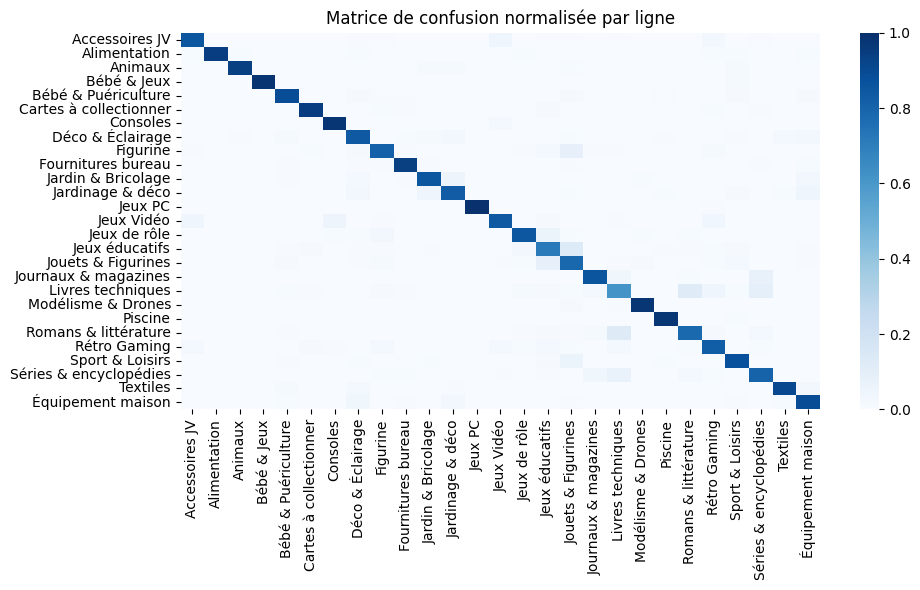

,precision,recall,f1-score,support
Jouets & Figurines,0.792,0.789,0.790,734.0
Romans & littérature,0.775,0.783,0.779,410.0
Jeux de rôle,0.643,0.851,0.733,87.0
Jeux éducatifs,0.592,0.716,0.648,257.0
Livres techniques,0.660,0.614,0.636,502.0


,Classe réelle,Classe prédite,% des prédictions de la classe réelle
0,Jeux éducatifs,Jouets & Figurines,13.2
1,Romans & littérature,Livres techniques,12.7
2,Livres techniques,Romans & littérature,12.0
3,Livres techniques,Séries & encyclopédies,9.6
4,Jouets & Figurines,Jeux éducatifs,8.6


In [50]:
y_pred = model.predict(X_test)
plot_classification_report(y_pred, y_test, encoder=encoder)

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<p>
L’évaluation du modèle sur le jeu de test conduit à un
<b>F1-weighted de 0.873</b>, confirmant une bonne capacité de généralisation et la
pertinence des choix méthodologiques effectués lors des phases de benchmark.
</p>

<p>
Les catégories présentant les performances les plus faibles correspondent
principalement à des <b>classes sémantiquement proches ou partiellement
chevauchantes</b>. Les confusions observées concernent notamment :
</p>

<ul>
  <li><b>Jeux éducatifs ↔ Jouets & Figurines</b>, reflétant des descriptions souvent
  génériques et orientées usage plutôt que contenu pédagogique explicite ;</li>
  <li><b>Romans & littérature ↔ Livres techniques</b>, deux catégories partageant un
  vocabulaire commun autour du format livre, avec des descriptions parfois peu
  spécialisées ;</li>
  <li><b>Jeux de rôle</b>, caractérisés par un rappel élevé mais une précision plus
  faible, traduisant une tendance du modèle à sur-prédire cette classe dès lors
  que certains marqueurs lexicaux sont présents.</li>
</ul>
</div>



<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<h2>III - Analyse et interprétation des features textuelles</h2>

<p>
Afin de mieux comprendre l’apport des différentes composantes de la représentation textuelle,
les features sont regroupées par <b>famille</b> :
</p>

<ul>
  <li>Word n-grams du titre</li>
  <li>Char n-grams du titre</li>
  <li>Word n-grams de la description</li>
  <li>Char n-grams de la description</li>
</ul>

<p>
Les coefficients associés à chaque feature sont ensuite agrégés par famille
afin d’obtenir une mesure synthétique de l’importance relative de chaque branche.
</p>

<p>
Cette analyse permet notamment de répondre aux questions suivantes :
</p>

<ul>
  <li>Le titre est-il plus informatif que la description ?</li>
  <li>Les char-ngrams apportent-ils un gain par rapport aux word-ngrams ?</li>
  <li>Quelle combinaison de features est la plus discriminante ?</li>
</ul>

</div>


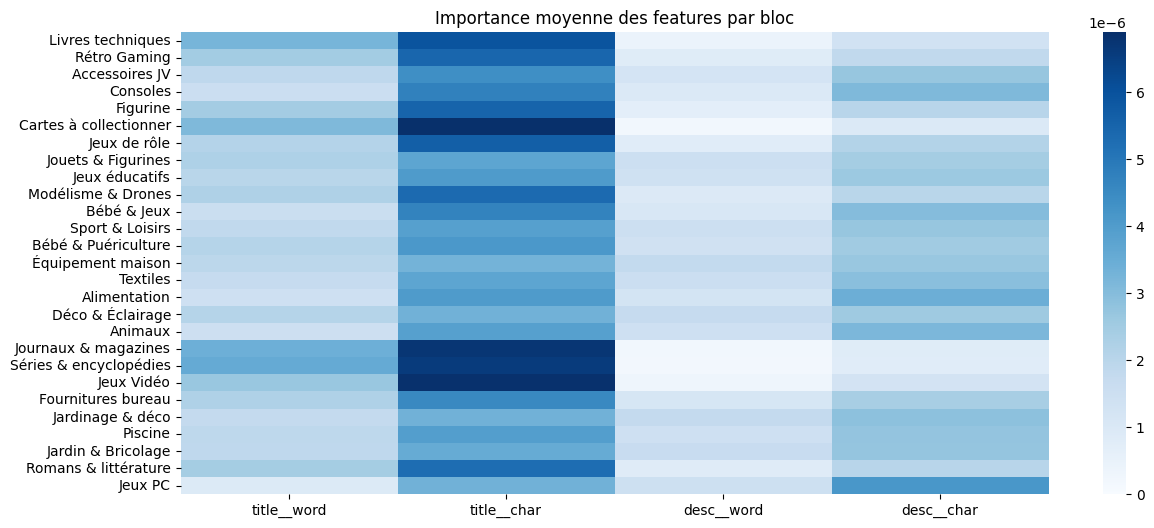

In [38]:
feature_names = model.named_steps['vectorizer'].get_feature_names_out()
feature_names = np.array(feature_names, dtype=str)
ranges = {
    "title__word": np.where(np.char.startswith(feature_names, "title__word__"))[0],
    "title__char": np.where(np.char.startswith(feature_names, "title__char__"))[0],
    "desc__word":  np.where(np.char.startswith(feature_names, "desc__word__"))[0],
    "desc__char":  np.where(np.char.startswith(feature_names, "desc__char__"))[0],
}

coef = model.named_steps['clf'].coef_
# on normalise par ligne pour éviter que pour les catégories avec une faible marge on ne puisse pas analyser leur principaux facteur sur la heatmap
coef_norm = coef / (np.abs(coef).sum(axis=1, keepdims=True))

plot_features_importance(coef_norm, ranges, model.classes_, by_block=False)

<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
L’analyse met en évidence l’importance du <b>titre</b>, et plus particulièrement
de la <b>vectorisation par n-grams de caractères appliquée au titre</b>, dans la
détermination des hyperplans de séparation du modèle. Ces caractéristiques
jouent un rôle central dans la discrimination des catégories de produits.
</p>

<p>
Toutefois, certaines catégories présentent un comportement différent. Pour les
produits de type <b>jeux PC</b>, la <b>description</b> contribue davantage à la
décision du modèle. Ce résultat est cohérent avec les observations issues du
notebook d’exploration, où les descriptions associées à cette catégorie étaient
particulièrement longues et riches en information.
</p>

<p>
À l’inverse, pour des catégories telles que les <b>cartes à collectionner</b>,
où les descriptions sont généralement très courtes voire absentes, la séparation
repose quasi exclusivement sur les informations contenues dans le titre, capturées
par la vectorisation textuelle.
</p>

</div>


In [91]:
from data import CATEGORY_SHORT_NAMES
class_labels = [CATEGORY_SHORT_NAMES[c] for c in model.classes_]
abs_coef = np.abs(coef)
# on récupère les k plus importante feature par catégorie
k = 5
idx = np.argpartition(abs_coef, -k, axis=1)[:, -k:]
df = pd.DataFrame(feature_names[idx], index=class_labels, columns=[f"top {i}" for i in range(1, 1+k)])

In [92]:
# pour la lisibilité on enlève les long suffixe et on utilise la coloration pour connaitre de quel vectorisation provient la feature

from IPython.display import display, HTML

def color(val):
    if val.startswith("title__word__"):
        return "color: #1f77b4; font-weight: bold"   # bleu
    if val.startswith("title__char__"):
        return "color: #2ca02c"                      # vert
    if val.startswith("desc__word__"):
        return "color: #d62728"                      # rouge
    if val.startswith("desc__char__"):
        return "color: #9467bd"                      # violet
    return ""

legend = """
<ul>
<li><span style="color:#1f77b4">title__word</span></li>
<li><span style="color:#2ca02c">title__char</span></li>
<li><span style="color:#d62728">desc__word</span></li>
<li><span style="color:#9467bd">desc__char</span></li>
</ul>
"""

display(HTML(legend))
display(
    df
    .style
    .map(color_feature)
    .format(lambda x: x.split("__", 2)[-1])
)

,top 1,top 2,top 3,top 4,top 5
Livres techniques,of,in,and,edition de,lot
Rétro Gaming,lot,quickio,:,import,ensemble complet
Accessoires JV,notice de,manette,magideal,ps4,quickio
Consoles,pack xbox,go,sony playstation,game watch,console
Figurine,shirt,watermelon,ver,mug,magnet
Cartes à collectionner,carte,-fr,fr0,vf,vo
Jeux de rôle,d&d,oop,warhammer,heroclix,«
Jouets & Figurines,-gé,-gén,générique,-géné,kinder
Jeux éducatifs,tarot,jeu,propos,jeu,loto
Modélisme & Drones,1/,générique,-gé,-géné,-gén


<div style="background:#f0f8ff; padding:12px; border-radius:6px">

<p>
L’analyse qualitative des <i>top features</i> textuelles met en évidence des
comportements contrastés selon les catégories, tant en termes de richesse
sémantique que de pouvoir discriminant pour le modèle.
</p>

<p>
La catégorie <b>Jeux Vidéo</b> repose principalement sur des termes génériques et
fonctionnels (<i>jeu</i>, <i>pc</i>, <i>téléchargement</i>), décrivant davantage le
type de produit ou le mode de vente que son contenu. Cette généricité limite la
séparabilité et induit un risque de confusion avec des classes proches.
</p>

<p>
À l’inverse, la catégorie <b>Consoles</b> bénéficie de la présence de noms propres
très spécifiques (<i>xbox</i>, <i>playstation</i>, <i>game watch</i>), offrant un
signal fort et une excellente séparation dans l’espace vectoriel.
</p>

<p>
La catégorie <b>Rétro Gaming</b> se caractérise par des tokens liés au style des
annonces (<i>lot</i>, <i>ensemble complet</i>, <i>import</i>), reflétant davantage
des pratiques commerciales que des attributs sémantiques intrinsèques, ce qui la
rend plus fragile et sensible au sur-apprentissage.
</p>

<p>
Enfin, les <b>Cartes à collectionner</b> s’appuient sur un lexique métier précis
(<i>vf</i>, <i>vo</i>, <i>-fr</i>), largement partagé par les collectionneurs,
assurant une très bonne discriminabilité.
</p>

<p>
En synthèse, les catégories fondées sur un jargon spécifique ou des noms propres
sont naturellement bien séparées, tandis que les catégories plus génériques
bénéficieraient d’un enrichissement via des <i>char-ngrams</i> ou une fusion
texte–image.
</p>

</div>


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>IV - Conclusion générale</h2>

<p>
Ce notebook a présenté une démarche méthodologique complète visant à construire
et optimiser un <b>modèle de classification textuelle robuste et interprétable</b>,
à partir des descriptions produits. L’approche adoptée repose sur une exploration
progressive et contrôlée des différentes composantes du pipeline de traitement du
texte, chaque étape s’appuyant sur les résultats de la précédente.
</p>

<p>
Les expériences menées ont montré que la combinaison d’une
<b>vectorisation TF-IDF</b> enrichie par des <b>n-grams de caractères</b>, associée
à une <b>séparation explicite du titre et de la description</b> avec pondération
différentielle, permet d’améliorer significativement la capacité de
discrimination du modèle. Le classifieur <b>LinearSVC</b>, correctement régularisé,
offre dans ce cadre un excellent compromis entre performance, stabilité et coût
de calcul.
</p>

<p>
L’analyse qualitative des coefficients du modèle a permis de relier les
performances observées aux caractéristiques sémantiques des données, en mettant
en évidence des comportements différenciés selon les catégories de produits.
Cette interprétabilité constitue un atout majeur, tant pour la compréhension du
modèle que pour la validation des choix méthodologiques effectués.
</p>

<p>
Le modèle final retenu, entraîné sur l’ensemble des données
d’apprentissage disponibles, fournit ainsi un <b>socle solide et justifié</b>
pour la suite du projet. Il est utilisé à la fois comme modèle autonome de
référence et comme <b>composant clé dans la stratégie de stacking</b>, où il sera
combiné à d’autres sources d’information complémentaires.
</p>

<p>
Plus globalement, ce travail illustre l’importance d’une optimisation raisonnée
de la représentation textuelle, privilégiant la compréhension et la
généralisation du modèle plutôt qu’une recherche aveugle de performance brute.
</p>

</div>
